In [1]:
include("model.jl")
include("Parser.jl")
using JuMP
using Plots

## Data processing

In [2]:
n, m, x_VC, y_VC, x_loc, y_loc, Q, C, q, f, p, tc, B, R, localities_with_high_priorities, M = parse_instance("./Instances/coord20-5-1_processed.dat")


(20, 5, [6.0, 19.0, 37.0, 35.0, 5.0], [7.0, 44.0, 23.0, 6.0, 8.0], [20.0, 8.0, 29.0, 18.0, 19.0, 31.0, 38.0, 33.0, 2.0, 1.0, 26.0, 20.0, 15.0, 20.0, 17.0, 15.0, 5.0, 13.0, 38.0, 9.0], [35.0, 31.0, 43.0, 39.0, 47.0, 24.0, 50.0, 21.0, 27.0, 12.0, 20.0, 33.0, 46.0, 26.0, 19.0, 12.0, 30.0, 40.0, 5.0, 40.0], 70, [140, 140, 140, 140, 140], [17, 18, 13, 19, 12, 18, 13, 13, 17, 20, 16, 18, 15, 11, 18, 16, 15, 15, 15, 16], [10841, 11961, 6091, 7570, 7497], 1000, 0, 15549.245317275838, [13.958791596349233, 12.114607178090317, 9.951277348331352, 12.467724566948226, 14.326988158440654], [12, 5, 15], 5)

In [3]:
# Create the distance matrix
distance_matrix = zeros(Float64, m, n)

for i in 1:m 
    for j in 1:n
        distance_matrix[i, j] = sqrt((x_VC[i] - x_loc[j])^2 + (y_VC[i] - y_loc[j])^2)
    end
end


# Create reachability matrix a
A = zeros(Int, n, n)


for i in 1:m
    for j in 1:n
        if distance_matrix[i, j] <= R[i]
            A[i, j] = 1
        end
    end
end

In [4]:
D = zeros(Float64, n+m, n+m)
#The n first rows/cols of D relate to the localities, the m last to the VC
#In other words, calling D[i,j] for i in I, j in J corresponds to call D[i+n,j]
for i in 1:m+n
    for j in 1:m+n
        if i <= n && j <= n
            # Both indices in `loc`
            D[i, j] = sqrt((x_loc[i] - x_loc[j])^2 + (y_loc[i] - y_loc[j])^2)
        elseif i > n && j > n
            # Both indices in `VC`
            D[i, j] = sqrt((x_VC[i - n] - x_VC[j - n])^2 + (y_VC[i - n] - y_VC[j - n])^2)
        elseif i > n && j <= n
            # i in `VC`, j in `loc`
            D[i, j] = sqrt((x_VC[i - n] - x_loc[j])^2 + (y_VC[i - n] - y_loc[j])^2)
        else
            # i in `loc`, j in `VC`
            D[i, j] = sqrt((x_loc[i] - x_VC[j - n])^2 + (y_loc[i] - y_VC[j - n])^2)
        end
    end
end

## Models Creation

### OptVax1

In [5]:
model_OptVax1 = solve_OptVax1(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)

obj_val = objective_value(model_OptVax1)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+04]
  Cost   [1e+01, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+04]
Presolving model
6262 rows, 3048 cols, 27839 nonzeros  0s
4758 rows, 3046 cols, 24713 nonzeros  0s
4296 rows, 2794 cols, 91092 nonzeros  1s
Objective function is integral with scale 1

Solving MIP model with:
   4296 rows
   2794 cols (2794 binary, 0 integer, 0 implied int., 0 continuous)
   91092 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   315             -inf                 inf        0      0      0         0     1.7s
         0       0         0   0.00%   265             -inf                 inf        0      0     12       548    

### OptVax2

In [6]:
model_OptVax2 = solve_OptVax2(n, m, D, A, Q, C, q, f, p, B, R, localities_with_high_priorities, M)
obj_val = objective_value(model_OptVax2)
println("Objective Value: ", obj_val)

Running HiGHS 1.8.0 (git hash: fcfb53414): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 1e+04]
  Cost   [1e+01, 2e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 2e+04]
Presolving model
3388 rows, 3173 cols, 22388 nonzeros  0s
3132 rows, 2919 cols, 20341 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   3132 rows
   2919 cols (2919 binary, 0 integer, 0 implied int., 0 continuous)
   20341 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   315             -inf                 inf        0      0      0         0     0.8s
         0       0         0   0.00%   265             -inf                 inf        0      0      6       187     0.8s
 R       0       0         0   0.00

In [7]:
function plot_solution(model, x_VC, y_VC, x_loc, y_loc, R, n, m, M, localities_with_high_priorities)
    # Retrieve the optimized values of y, z, and delta from the model
    y_values = value.(model[:y])
    z_values = value.(model[:z])  # z_values is a 3D array with dimensions (i, j, k)
    delta_values = value.(model[:delta])

    # Create a new plot
    color = :blue
    plt = plot()
        # Plot loc points without adding them to the legend (but with single labels for groups)
    first_black = true
    first_green = true
    for j in 1:n
        if j in localities_with_high_priorities
            # Plot green square points and add label only for the first one
            if first_green
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:green, marker=:square, aspect_ratio=:equal, label="High priority")
                first_green = false
            else
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:green, marker=:square, aspect_ratio=:equal, label="")
            end
        else
            # Plot black circle points and add label only for the first one
            if first_black
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:black, marker=:circle, aspect_ratio=:equal, label="Low priority")
                first_black = false
            else
                scatter!(plt, [x_loc[j]], [y_loc[j]], color=:black, marker=:circle, aspect_ratio=:equal, label="")
            end
        end
    end

    # For each VC point, check if y[i] is 1; if so, plot in red and add a shaded circle
    for i in 1:length(x_VC)
        if y_values[i] == 1
            # Plot the VC point in red
            scatter!(plt, [x_VC[i]], [y_VC[i]], color=:red, marker=:star5, label="VC")

            # Draw a shaded circle of radius R[i] around the VC location
            θ = range(0, 2π, length=100)
            circle_x = x_VC[i] .+ R[i] .* cos.(θ)
            circle_y = y_VC[i] .+ R[i] .* sin.(θ)
            plot!(plt, circle_x, circle_y, lw=1.5, linecolor=:red, label="", fillalpha=0.1, fillcolor=:red)
        end
    end

    # Create a color gradient (you can use other gradient types too)
    color_map = [:blue,:red,:green,:yellow,:orange]

    # For all z[i,j,k], draw arrows only if z[i,j,k] == 1 for any k
    for i in 1:(m+n)
        for j in 1:(m+n)
            # Check if z[i, j, k] == 1 for any k
            for k in 1:M
                if z_values[i, j, k] == 1.0
                    # Scale the color based on the value of k, you can normalize it if needed
                    color = color_map[k]  # This gives a color based on the value of k

                    # Create the arrows with the color mapped to k
                    if i <= n && j <= n
                        # Arrow from loc[i] to loc[j]
                        dx = x_loc[j] - x_loc[i]
                        dy = y_loc[j] - y_loc[i]
                        quiver!(plt, [x_loc[i]], [y_loc[i]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i > n && j > n
                        # Arrow from VC[i] to VC[j]
                        dx = x_VC[j - n] - x_VC[i - n]
                        dy = y_VC[j - n] - y_VC[i - n]
                        quiver!(plt, [x_VC[i - n]], [y_VC[i - n]], quiver=([dx],[dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i <= n && j > n
                        # Arrow from loc[i] to VC[j]
                        dx = x_VC[j - n] - x_loc[i]
                        dy = y_VC[j - n] - y_loc[i]
                        quiver!(plt, [x_loc[i]], [y_loc[i]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    elseif i > n && j <= n
                        # Arrow from VC[i] to loc[j]
                        dx = x_loc[j] - x_VC[i - n]
                        dy = y_loc[j] - y_VC[i - n]
                        quiver!(plt, [x_VC[i - n]], [y_VC[i - n]], quiver=([dx], [dy]), color=color, linewidth=1, arrowhead=2)
                    end
                end
            end
        end
    end

    # Display the final plot
    savefig(plt, "test.png")
    display(plt)
end


plot_solution (generic function with 1 method)

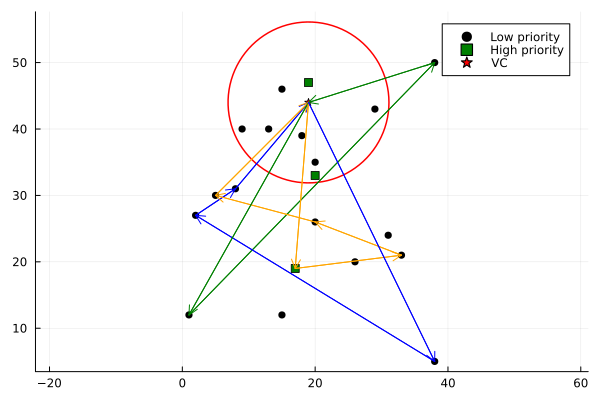

In [8]:
plot_solution(model_OptVax1, x_VC, y_VC, x_loc, y_loc, R,n,m,M, localities_with_high_priorities)

In [9]:
print(value.(model_OptVax1[:delta]))

[1.0, 0.0, 1.0, 0.0, 1.0]